In [47]:
from birdclef.utils import cens_per_sec
import IPython.display as ipd
import librosa
import numpy as np

In [6]:
data, sample_rate = librosa.load("../data/input/train_short_audio/acafly/XC6671.ogg")
cens = librosa.feature.chroma_cens(
    data, sample_rate, hop_length=cens_per_sec(sample_rate, 4)
)

In [7]:
cens.shape

(12, 127)

In [97]:
import pandas as pd

df = pd.read_pickle("../data/cens_v2/train_short_audio/batpig1/data.pkl.gz")
df

,name,parent,seconds,cens,cens_sample_rate,path
0,XC119742,batpig1,33.059093,"[[0.3441820288734709, 0.34658471935920215, 0.3...",4,data/input/train_short_audio/batpig1/XC119742.ogg
1,XC119743,batpig1,23.080317,"[[0.3766751443682947, 0.372260322134855, 0.367...",4,data/input/train_short_audio/batpig1/XC119743.ogg
2,XC129053,batpig1,14.851746,"[[0.3545890701601338, 0.3500902011266105, 0.34...",4,data/input/train_short_audio/batpig1/XC129053.ogg
3,XC131474,batpig1,99.901043,"[[0.22539412624200286, 0.2243425204252583, 0.2...",4,data/input/train_short_audio/batpig1/XC131474.ogg
4,XC133004,batpig1,167.077007,"[[0.29046361338377796, 0.29376980244578593, 0....",4,data/input/train_short_audio/batpig1/XC133004.ogg
...,...,...,...,...,...,...
80,XC610423,batpig1,532.813016,"[[0.2621520267709573, 0.2592906178387941, 0.25...",4,data/input/train_short_audio/batpig1/XC610423.ogg
81,XC610424,batpig1,32.821043,"[[0.2749177184480727, 0.2769430573045141, 0.27...",4,data/input/train_short_audio/batpig1/XC610424.ogg
82,XC73442,batpig1,132.272154,"[[0.2707586523070058, 0.27427906683372333, 0.2...",4,data/input/train_short_audio/batpig1/XC73442.ogg
83,XC73443,batpig1,9.444399,"[[0.3373923045137964, 0.3340844835815801, 0.33...",4,data/input/train_short_audio/batpig1/XC73443.ogg


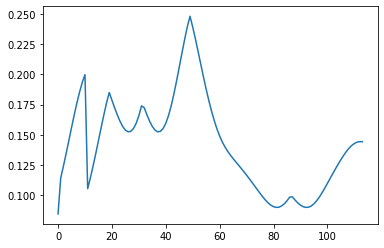

In [132]:
from simple_mp.simple import simple_fast
import lkj

row = df.cens[0]
mp, pi = simple_fast(row, row, 20)
plt.plot(mp)

<AxesSubplot:>

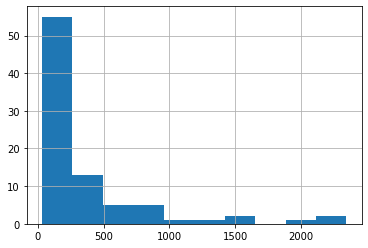

In [98]:
from collections import Counter
df.cens.apply(lambda x: x.shape[1]).hist()

In [135]:
import networkx as nx
import numpy as np
import pandas as pd
import tqdm
from scipy.stats import median_abs_deviation
from simple_mp.simple import simple_fast

from birdclef.utils import aligned_slice_indices, get_transition_index

def compute_motif(cens, window=20):
    mp, pi = simple_fast(cens, cens, window)
    return mp.argmin()


def compute_affinity(df, window=50, sample=100):
    n = df.shape[0]
    aff = np.zeros((n, n))

    # slow n^2 computation, so we sample...
    if sample is None or n <= sample:
        indices = np.arange(n)
    else:
        # limit the indices we compute to the number of sampled items.
        # Unfortunately this makes the training set non-deterministic (which is
        # probably fine anyhow). Taking the best 5 out of 100 seems good...
        indices = np.random.choice(np.arange(n), sample, replace=False)
    for off, i in enumerate(indices):
        row = df.iloc[i]
        motif = row.cens[:, row.motif : row.motif + window]
        for j in indices[off:]:
            mp, _ = simple_fast(df.iloc[j].cens, motif, window // 2)
            # i wish i could keep each of the matrix profiles...
            aff[i][j] = mp.min()
            aff[j][i] = mp.min()
    return aff



def create_digraph(affinity):
    k = 1.4826
    # there may be large number of 0 elements, ignore them
    masked = np.ma.masked_where(affinity == 0, affinity)
    unmasked = masked[masked.mask == False].reshape(-1).filled(0)
    mad = median_abs_deviation(unmasked)
    zscores = (masked - np.median(unmasked)) / (k * mad)
    dropped = masked * (zscores < 1)
    normed = dropped / dropped.sum()
    return nx.from_numpy_matrix(normed.filled(0), create_using=nx.DiGraph)


def get_reference_motif(df, G, k=5, window=20):
    pr = nx.pagerank(G)
    ranked = sorted([(score, idx) for idx, score in pr.items()])
    best = [idx for _, idx in ranked[-k:]]
    return df.iloc[best].apply(lambda r: r.cens[:, r.motif : r.motif + window], axis=1)


def extract_samples(cens, indices, window=50):
    aligned = aligned_slice_indices(cens.shape[1], indices, window)
    return list(zip([cens[:, i:j] for i, j in aligned], aligned))


In [136]:
df["motif"] = df.cens.apply(compute_motif)

In [101]:
aff = compute_affinity(df, window=20, sample=100)

In [102]:
G = create_digraph(aff)

In [103]:
motifs = get_reference_motif(df, G, 8, 20)
motifs

43    [[0.24234320645427557, 0.24417324648561434, 0....
44    [[0.26763560603672704, 0.2662796533704299, 0.2...
79    [[0.29930067582992814, 0.3001955929871789, 0.3...
13    [[0.31725590245868857, 0.312479706115588, 0.30...
8     [[0.299655632903226, 0.2985462815188977, 0.297...
9     [[0.23924022498739142, 0.2382001667888218, 0.2...
72    [[0.2208301987379612, 0.22192312929364394, 0.2...
69    [[0.37289772647885977, 0.37476626218524056, 0....
dtype: object

In [104]:
# hmm, convert this to the original data...
df_v1 = pd.read_pickle("../data/cens/train_short_audio/batpig1/data.pkl.gz")

In [105]:
df.iloc[motifs.index]

,name,parent,seconds,cens,cens_sample_rate,path,motif
43,XC323711,batpig1,46.982358,"[[0.2609518036241053, 0.26120002642017603, 0.2...",4,data/input/train_short_audio/batpig1/XC323711.ogg,56
44,XC323712,batpig1,17.986440,"[[0.24104269939286319, 0.24366392493020414, 0....",4,data/input/train_short_audio/batpig1/XC323712.ogg,42
79,XC610422,batpig1,19.429025,"[[0.29930067582992814, 0.3001955929871789, 0.3...",4,data/input/train_short_audio/batpig1/XC610422.ogg,0
13,XC2183,batpig1,11.142358,"[[0.31725590245868857, 0.312479706115588, 0.30...",4,data/input/train_short_audio/batpig1/XC2183.ogg,0
8,XC153416,batpig1,101.173016,"[[0.2753114956256075, 0.2704315789821529, 0.26...",4,data/input/train_short_audio/batpig1/XC153416.ogg,53
9,XC184229,batpig1,10.429025,"[[0.23924022498739142, 0.2382001667888218, 0.2...",4,data/input/train_short_audio/batpig1/XC184229.ogg,0
72,XC529639,batpig1,23.341542,"[[0.2563506998092867, 0.25729363123888255, 0.2...",4,data/input/train_short_audio/batpig1/XC529639.ogg,41
69,XC518072,batpig1,121.091746,"[[0.35080412374347736, 0.3465056128228467, 0.3...",4,data/input/train_short_audio/batpig1/XC518072.ogg,47


In [106]:
orig = df_v1[["data", "sample_rate"]].join(df.iloc[motifs.index], how="right")
orig

,data,sample_rate,name,parent,seconds,cens,cens_sample_rate,path,motif
43,"[5.053127e-06, 7.106025e-06, 6.771941e-06, 7.2...",22050,XC323711,batpig1,46.982358,"[[0.2609518036241053, 0.26120002642017603, 0.2...",4,data/input/train_short_audio/batpig1/XC323711.ogg,56
44,"[-4.688613e-06, -6.583714e-06, -6.42366e-06, -...",22050,XC323712,batpig1,17.986440,"[[0.24104269939286319, 0.24366392493020414, 0....",4,data/input/train_short_audio/batpig1/XC323712.ogg,42
79,"[-8.773468e-05, -0.00010680864, -0.00013023238...",22050,XC610422,batpig1,19.429025,"[[0.29930067582992814, 0.3001955929871789, 0.3...",4,data/input/train_short_audio/batpig1/XC610422.ogg,0
13,"[-0.033255458, -0.047644865, -0.043395095, -0....",22050,XC2183,batpig1,11.142358,"[[0.31725590245868857, 0.312479706115588, 0.30...",4,data/input/train_short_audio/batpig1/XC2183.ogg,0
8,"[-3.7125385e-06, -5.669981e-06, -5.2613477e-06...",22050,XC153416,batpig1,101.173016,"[[0.2753114956256075, 0.2704315789821529, 0.26...",4,data/input/train_short_audio/batpig1/XC153416.ogg,53
9,"[1.4425185e-06, 2.172345e-06, 2.2055094e-06, 2...",22050,XC184229,batpig1,10.429025,"[[0.23924022498739142, 0.2382001667888218, 0.2...",4,data/input/train_short_audio/batpig1/XC184229.ogg,0
72,"[3.4724915e-06, 4.5683028e-06, 4.199537e-06, 4...",22050,XC529639,batpig1,23.341542,"[[0.2563506998092867, 0.25729363123888255, 0.2...",4,data/input/train_short_audio/batpig1/XC529639.ogg,41
69,"[-0.00016564678, -0.00023989216, -0.0002124746...",22050,XC518072,batpig1,121.091746,"[[0.35080412374347736, 0.3465056128228467, 0.3...",4,data/input/train_short_audio/batpig1/XC518072.ogg,47


In [134]:
from birdclef.utils import compute_offset

for row in orig.itertuples():
    a,b = compute_offset(row.motif, 20, row.cens.shape[1], row.data.shape[0])
    print(row.name)
    ipd.display(ipd.Audio(row.data[a:b], rate=row.sample_rate))

XC323711


XC323712


XC610422


XC2183


XC153416


XC184229


XC529639


XC518072


In [108]:
motifs

43    [[0.24234320645427557, 0.24417324648561434, 0....
44    [[0.26763560603672704, 0.2662796533704299, 0.2...
79    [[0.29930067582992814, 0.3001955929871789, 0.3...
13    [[0.31725590245868857, 0.312479706115588, 0.30...
8     [[0.299655632903226, 0.2985462815188977, 0.297...
9     [[0.23924022498739142, 0.2382001667888218, 0.2...
72    [[0.2208301987379612, 0.22192312929364394, 0.2...
69    [[0.37289772647885977, 0.37476626218524056, 0....
dtype: object

In [109]:
profiles = []
for full in df.cens:
    row_profiles = []
    for motif in motifs:
        mp, _ = simple_fast(full, motif, 10)
        row_profiles.append(mp)
    profiles.append(row_profiles)

computed = []
for row in profiles:
    arr = np.array(row)
    averaged = np.median(arr, axis=0)
    med = np.median(arr)
    computed.append(
        dict(
            profile=averaged,
            median=med,
            indices=get_transition_index(averaged < med, 5),
        )
    )
computed_df = pd.DataFrame(computed)

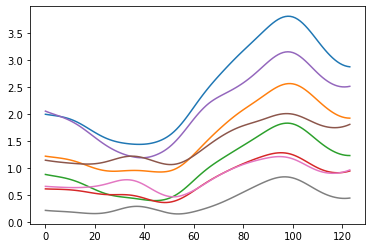

In [110]:
import matplotlib.pyplot as plt

for row in profiles[0]:
    plt.plot(row)

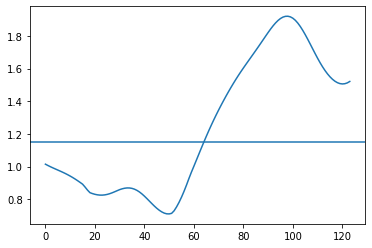

In [111]:
row = computed_df.iloc[0]
plt.plot(row.profile)
plt.axhline(row["median"])

In [112]:
np.array(row.indices) / 4

array([[ 0. , 17.5]])

In [133]:
path = df.iloc[0].path
print(path)
ipd.Audio("../" + path)

data/input/train_short_audio/batpig1/XC119742.ogg
